# EEE6504 - Project 1 #
## Jackson Cornell ##

In [1]:
import math
import time
import scipy.io
import numpy as np
from numpy import random
from scipy import signal
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz
from scipy.stats import levy_stable
from IPython.lib.display import Audio
from statsmodels.graphics.tsaplots import plot_acf

## Functions ##

In [2]:
# Affine projection using gradient descent and non-regularized solution
def APA1(x, d, K, L, mu) :
    # number of iterations
    epochs = np.size(x) - L - K
    # initialize weights
    w = np.zeros(K)
    y = np.zeros(epochs)
    w_traces = np.zeros([epochs,K])
    J = np.zeros(epochs)
    # iterate through data stream
    for i in range(epochs) :
        # construct input matrix
        X = np.zeros((K, L))
        for l in range(L) :
            X[:,l] = x[(i+l):(i+l+K)]
        # construct desired vector
        D = d[(i+K):(i+K+L)]
        # update weights
        w = w + mu*X@(D - X.T@w)
        # update traces, learning curve, and output
        w_traces[i,:] = w
        y[i] = d[i+K+L-1] - w.T@x[(i+L-1):(i+L+K-1)]
        J[i] = y[i]**2
    return w, w_traces, J, y

# Affine projection using newton's method and non-regularized solution
def APA2(x, d, K, L, mu, eps) :
    # number of iterations
    epochs = np.size(x) - L - K
    # initialize weights
    w = np.zeros(K)
    y = np.zeros(epochs)
    w_traces = np.zeros([epochs,K])
    J = np.zeros(epochs)
    # iterate through data stream
    for i in range(epochs) :
        # construct input matrix
        X = np.zeros((K, L))
        for l in range(L) :
            X[:,l] = x[(i+l):(i+l+K)]
        # construct desired vector
        D = d[(i+K):(i+K+L)]
        # update weights
        w = w + mu*X@np.linalg.inv(X.T@X + eps*np.identity(L))@(D - X.T@w)
        # update traces, learning curve, and output
        w_traces[i,:] = w
        y[i] = d[i+K+L-1] - w.T@x[(i+L-1):(i+L+K-1)]
        J[i] = y[i]**2
    return w, w_traces, J, y

# Affine projection using gradient descent and regularized solution
def APA3(x, d, K, L, mu, lam) :
    # number of iterations
    epochs = np.size(x) - L - K
    # initialize weights
    w = np.zeros(K)
    y = np.zeros(epochs)
    w_traces = np.zeros([epochs,K])
    J = np.zeros(epochs)
    # iterate through data stream
    for i in range(epochs) :
        # construct input matrix
        X = np.zeros((K, L))
        for l in range(L) :
            X[:,l] = x[(i+l):(i+l+K)]
        # construct desired vector
        D = d[(i+K):(i+K+L)]
        # update weights
        w = (1 - mu*lam)*w + mu*X@(D - X.T@w)
        # update traces, learning curve, and output
        w_traces[i,:] = w
        y[i] = d[i+K+L-1] - w.T@x[(i+L-1):(i+L+K-1)]
        J[i] = y[i]**2
    return w, w_traces, J, y

# Affine projection using newton's method and regularized solution
def APA4(x, d, K, L, mu, lam) :
    # number of iterations
    epochs = np.size(x) - L - K
    # initialize weights
    w = np.zeros(K)
    y = np.zeros(epochs)
    w_traces = np.zeros([epochs,K])
    J = np.zeros(epochs)
    # iterate through data stream
    for i in range(epochs) :
        # construct input matrix
        X = np.zeros((K, L))
        for l in range(L) :
            X[:,l] = x[(i+l):(i+l+K)]
        # construct desired vector
        D = d[(i+K):(i+K+L)]
        # update weights
        w =(1 - mu)*w + mu*X@np.linalg.inv(X.T@X + lam*np.identity(L))@D
        # update traces, learning curve, and output
        w_traces[i,:] = w
        y[i] = d[i+K+L-1] - w.T@x[(i+L-1):(i+L+K-1)]
        J[i] = y[i]**2
    return w, w_traces, J, y

## Read data ##

In [3]:
# read matlab file
speech = scipy.io.loadmat('project1.mat')
fs = speech.get('fs')[0][0]
x = np.array(speech.get('primary')[0])
d = np.array(speech.get('reference')[0])

## 2-tap Filter Analysis ##

In [4]:
# filter data
K = 2
L = 10
mu = 0.002
size = np.size(x) - L - K
w, w_traces, J, y = APA2(x, d, K, L, mu , 0.01)

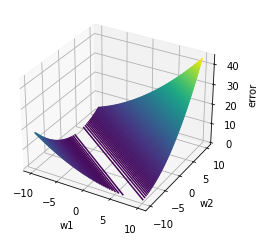

In [5]:
# plot weights performace surface contour
lag = math.floor(fs*1.5)
w1 = np.linspace(-10, 10, 1000)
w2 = np.linspace(-10, 10, 1000)
d_t = d[lag]
x_t = [x[lag-1], x[lag]]
e_t = np.zeros([1000,1000])
for i in range(1000) :
    for j in range(1000) :
        e_t[i, j] = (d_t - (w1[i]*x_t[0] + w2[j]*x_t[1]))**2
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(w1, w2, e_t, 250)
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_zlabel('error');

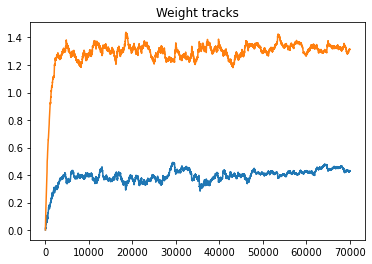

In [6]:
# plot weights track
plt.plot(np.linspace(0, size, size), w_traces[:,0])
plt.plot(np.linspace(0, size, size), w_traces[:,1])
plt.title("Weight tracks")
plt.show()

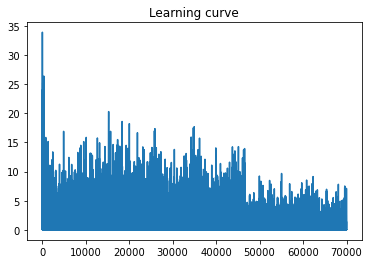

In [7]:
# plot the learning curve
plt.plot(np.linspace(0, size, size), J)
plt.title("Learning curve")
plt.show()

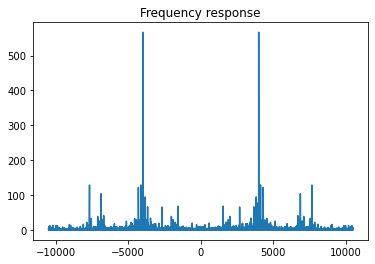

In [8]:
# estimate frequency response
y_t = np.concatenate([np.zeros(L+K),y])
d_freq = abs(np.fft.fft(d))
y_freq = abs(np.fft.fft(y_t))
H = y_freq / d_freq
plt.plot(np.linspace(-math.floor(fs/2), math.floor(fs/2), 70000), H)
plt.title("Frequency response")
plt.show()

In [9]:
# estimate SNR using ERLE
d_acf = np.correlate(d, d, mode='full')[0]
y_acf = np.correlate(y, y, mode='full')[0]
print("ERLE SNR Improvement (dB):", 10*math.log10(abs(d_acf / y_acf)))

ERLE SNR Improvement (dB): 14.806978268399087


In [10]:
# output audio
Audio(y, rate=fs)

## Optimal Filter Order Analysis ##

In [11]:
# iterate through several filter orders to find optimal weighting
K = np.array([18, 19, 20, 21, 22])
for k in K :
    w, w_traces, J, y = APA2(x, d, k, L, mu, 0.01)
    y_acfk = np.correlate(y, y, mode='full')[0]
    print("ERLE SNR Improvement (dB), K =", k, ":", 10*math.log10(abs(d_acf / y_acfk)))

ERLE SNR Improvement (dB), K = 18 : 8.617886305670856
ERLE SNR Improvement (dB), K = 19 : 15.176243014741523
ERLE SNR Improvement (dB), K = 20 : 17.30579774712182
ERLE SNR Improvement (dB), K = 21 : 12.796349855497395
ERLE SNR Improvement (dB), K = 22 : 9.366095633315703


In [12]:
# perform APA2 with K=20
K = 20
w, w_traces, J, y = APA2(x, d, K, L, mu, 0.01)

In [13]:
# output audio
Audio(y, rate=fs)

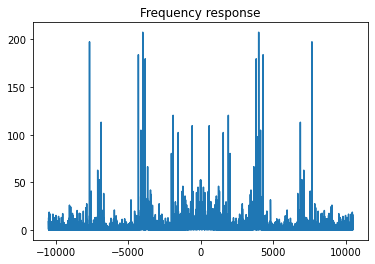

In [14]:
# estimate frequency response
y_t = np.concatenate([np.zeros(L+K),y])
d_freq = abs(np.fft.fft(d))
y_freq = abs(np.fft.fft(y_t))
H = y_freq / d_freq
plt.plot(np.linspace(-math.floor(fs/2), math.floor(fs/2), 70000), H)
plt.title("Frequency response")
plt.show()

In [15]:
# compute SNR improvement
d_acf = np.correlate(d, d, mode='full')[0]
y_acf = np.correlate(y, y, mode='full')[0]
print("ERLE SNR Improvement (dB):", 10*math.log10(abs(d_acf / y_acf)))

ERLE SNR Improvement (dB): 17.30579774712182


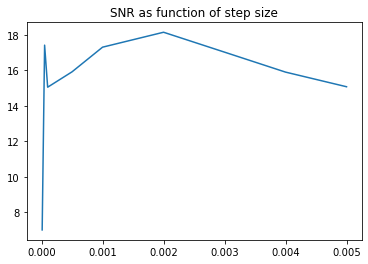

In [16]:
# evaluate performance as function of step size
mu = np.array([1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 2e-3, 3e-3, 4e-3, 5e-3])
ERLE = np.zeros(9)
i = 0
for m in mu :
    w, w_traces, J, y = APA2(x, d, K, L, m, 0.01)
    y_acfk = np.correlate(y, y, mode='full')[0]
    ERLE[i] = 10*math.log10(abs(d_acf / y_acfk))
    i += 1
    
# plot ERLE SNR as function of step size
plt.plot(mu, ERLE)
plt.title("SNR as function of step size")
plt.show()

In [17]:
# estimate misadjustment

## Conclusions ##
